<a href="https://colab.research.google.com/github/Mateocontrerass/Data_Science_projects/blob/main/Credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#__Credit card fraud detection__

## 1. Business Understanding

  The company _fraudCracker_ just opened its brand new offices in Colombia and looks forward to work with the country's biggest credit institutions.

  The business model is centered in blocking fraudulent transactions from which the company gets a share if it's truly fraudulent but can also lose money if the transaction is legitimate but was flagged as fraudulent.

  The company's pay and penalties structure works as follows:
  
  a. The company will recieve 15% of the value of each transaction made that is truly detected as fraud.
  
  b. The company will have a penalty of 3% of the value of each transaction made that is flagged as fraud but is legitimate.

## 2. The goal

  You as the lead Data Scientist in fraudCracker must deliver a classification model for the company.


## 3. Key questions

What is the expected billing?

What is the expected loss?

Is the model profitable?


In [1]:
import numpy as np
import polars as pl
import polars.selectors as cs

import warnings
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import  train_test_split


!pip install category_encoders

from category_encoders import OneHotEncoder
import gc
import pandas as pd

In [2]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [3]:
warnings.filterwarnings('ignore')

seed = 123
np.random.seed(seed)

## I. Loading the Data

In [4]:
!kaggle datasets download -d rupakroy/online-payments-fraud-detection-dataset -p /content/sample_data/ --unzip

Dataset URL: https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset
License(s): CC-BY-NC-SA-4.0
 98% 175M/178M [00:01<00:00, 99.3MB/s]
100% 178M/178M [00:01<00:00, 110MB/s] 


In [5]:
data = pl.read_csv("/content/sample_data/PS_20174392719_1491204439457_log.csv")

In [6]:
# Drop unnecesary columns or ones that we would not have access in a normal scenario

if "isFlaggedFraud" in data.columns:
  data=data.drop("isFlaggedFraud")

data = data.drop(["oldbalanceDest","newbalanceDest"])

## II. Data Understanding

### a. Columns


step: represents a unit of time where 1 step equals 1 hour

type: type of online transaction

amount: the amount of the transaction

nameOrig: customer starting the transaction

oldbalanceOrg: balance before the transaction

newbalanceOrig: balance after the transaction

nameDest: recipient of the transaction

isFraud: fraud transaction

### b. Data shape


In [7]:
print(f"The number of observations in the data set is {data.shape[0]:,}")
print(f"The number of columns in the data set is {data.shape[1]:,}")

The number of observations in the data set is 6,362,620
The number of columns in the data set is 8


### c. Data Info

In [8]:
data.schema

OrderedDict([('step', Int64),
             ('type', Utf8),
             ('amount', Float64),
             ('nameOrig', Utf8),
             ('oldbalanceOrg', Float64),
             ('newbalanceOrig', Float64),
             ('nameDest', Utf8),
             ('isFraud', Int64)])

In [9]:
print(f"The dataframe estimated size is {data.estimated_size('mb')} mb.")

The dataframe estimated size is 560.5888690948486 mb.


### d. Data NA


In [10]:
# There are no null values in the dataframe.
data.null_count()

step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,isFraud
u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0


In [11]:
data = data.drop_nulls()

### e. descriptive overview

In [12]:
data["type"].value_counts().sort("count")

type,count
str,u32
"""DEBIT""",41432
"""TRANSFER""",532909
"""CASH_IN""",1399284
"""PAYMENT""",2151495
"""CASH_OUT""",2237500


In [13]:
data["nameOrig"].value_counts().sort("count",descending=True).head(5)

nameOrig,count
str,u32
"""C2098525306""",3
"""C1784010646""",3
"""C363736674""",3
"""C1462946854""",3
"""C1530544995""",3


In [14]:
data.describe()

describe,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,isFraud
str,f64,str,f64,str,f64,f64,str,f64
"""count""",6.36262e6,"""6362620""",6.36262e6,"""6362620""",6.36262e6,6.36262e6,"""6362620""",6.36262e6
"""null_count""",0.0,"""0""",0.0,"""0""",0.0,0.0,"""0""",0.0
"""mean""",243.397246,null,179861.903549,null,833883.104074,855113.668579,null,0.001291
"""std""",142.331971,null,603858.231463,null,2.8882e6,2.9240e6,null,0.035905
"""min""",1.0,"""CASH_IN""",0.0,"""C1000000639""",0.0,0.0,"""C1000004082""",0.0
"""25%""",156.0,null,13389.57,null,0.0,0.0,null,0.0
"""50%""",239.0,null,74872.08,null,14208.0,0.0,null,0.0
"""75%""",335.0,null,208721.45,null,107315.0,144258.41,null,0.0
"""max""",743.0,"""TRANSFER""",9.2446e7,"""C999999784""",5.9585e7,4.9585e7,"""M999999784""",1.0


The step variable starts from 1 to 743 which roughly translates to 30,9 days.

The mode in the type of transaction is CASH_OUT.

The average amount per transaction is 179.861.

In the dataset, around 0.1% of all transactions are marked as fraud.

There is a lot of variability in the nameOrig variable so it would be hard to oneHotEncode.


## III. Data Engineering

In [15]:
def day_stage(column):
  day_hour = column %24
  if column==0:
    day_hour=24

  if 1<=day_hour<6:
    return "early_morning"
  elif 6<=day_hour<12:
    return "morning"
  elif 12<=day_hour<18:
    return "afternoon"
  else:
    return "night"

def week_day(column):
  # Get days
  day= (column-1)//24
  #Get weekday
  w_day = (day%7) +1

  return w_day


def categorize_change(pct_change):
    if pct_change < -0.5:
        return "Decrecimiento_importante"
    elif pct_change < -0.2:
        return "Decrecimiento_notable"
    elif pct_change < 0:
        return "Decrecimiento"
    elif pct_change==0:
        return "Sin_cambio"
    elif pct_change < 20:
        return "Incremento"
    elif pct_change < 50:
        return "Incremento_grande"
    else:
        return "Incremento_importante"


In [16]:
# Turning the step varaible into valuable date variables

# Day
data = data.with_columns(
    np.ceil(data["step"]/24).alias("day")
)

# Time of day
data = data.with_columns(
    data["step"].apply(day_stage).alias("day_stage")
)

# Week day
data = data.with_columns(
    data["step"].apply(week_day).alias("week_day").cast(pl.Utf8)
)

# Percentaje of balance transfered from origin account
data = data.with_columns(
    (((data["newbalanceOrig"]-data["oldbalanceOrg"]))/data["oldbalanceOrg"]).alias("pct_change")
)

data = data.with_columns(
    data["pct_change"].apply(categorize_change).alias("cat_change")
)

# Type of account sending and recieving the transaction

data = data.with_columns(
    data["nameOrig"].apply(lambda i: i[0]).alias("orig_acc")
)

data = data.with_columns(
    data["nameDest"].apply(lambda i: i[0]).alias("rec_acc")
)


data = data.drop(["oldbalanceDest","newbalanceDest"])

## IV. Exploratory Data Analysis

In [17]:
%%skip

sns.set(style="white")

ax = sns.countplot(data,x="isFraud",stat="percent")

# Add a title and labels
ax.set_title('Fraudulent vs Non-Fraudulent Transactions', fontsize=16)
ax.set_xlabel('Is Fraudulent', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)


ax.bar_label(ax.containers[0],fontsize=12)

# Change x-axis labels
ax.set_xticklabels(['Not fraudulent', 'Fraudulent'], fontsize=12)


# Display the plot
plt.show()

In [18]:
#@title Code

%%skip


# Seleccionar columnas categóricas
categorical_columns = ['type', 'day_stage', 'week_day','orig_acc','rec_acc']

sns.set(style="white")

# Crear un gráfico de barras apiladas del 100% para cada columna categórica
fig, axes = plt.subplots(nrows=len(categorical_columns), ncols=1, figsize=(10, len(categorical_columns) * 6))

for ax, column in zip(axes, categorical_columns):
    counts = data[column].value_counts().sort('count')
    total = counts['count'].sum()
    percentages = counts.with_columns((counts['count'] / total * 100).round(0).alias('percentage'))

    percentages.to_pandas().plot(kind='bar', x=column, y='percentage', stacked=True, ax=ax, colormap="Dark2")
    ax.bar_label(ax.containers[0],fontsize=12)
    ax.set_title(f'Percentage distribution for {column}')
    ax.set_ylabel('Percentage')
    ax.set_xlabel(column)

plt.tight_layout()
plt.show()

## Multivariate Analysis
### Numerical Analysis

In [19]:
%%skip
numeric_cols = data.select(cs.numeric()).corr()

plt.figure(figsize=(15,5))
sns.set(style="white")

with sns.axes_style("white"):
    ax = sns.heatmap(numeric_cols, annot=True, square=True,
                    xticklabels=numeric_cols.columns,  # Set column labels for x-axis
                    yticklabels=numeric_cols.columns)  # Set column labels for y-axis

## V. Data Preparation

In [20]:
df_m = data.clone()
y = df_m.select(["isFraud"])
x = df_m.drop(["step","isFraud","nameOrig","nameDest","pct_change"])

# Categorical variables
cat_vars = x.select(~cs.numeric()).columns

# Numerical variables
num_vars = x.select(cs.numeric()).columns

Split the datasets we are going to use to train and validate the model and the dataset we are going to use as if it was real world data to verify the viability of the model and the business.

In [21]:
# Save validation sets
x_model, x_val , y_model, y_val = train_test_split(x, y , test_size=.2,stratify=y)

# Make the train and test splits for the model training
x_train, x_test , y_train, y_test = train_test_split(x_model, y_model , test_size=.2, stratify=y_model)

### Rescaling

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

x_model_nums = (
  scaler.fit_transform(x_model.select(num_vars).to_pandas())
)

x_val_nums = (
  scaler.transform(x_val.select(num_vars).to_pandas())
)


x_train_nums = (
  scaler.fit_transform(x_train.select(num_vars).to_pandas())
)

x_test_nums = (
  scaler.transform(x_test.select(num_vars).to_pandas())
)


### OneHotEncoding

In [23]:
# One hot encoder
onehot = OneHotEncoder(cols=cat_vars,use_cat_names=True)

# Encode

x_model_cats = (
    onehot.fit_transform(x_model.select(cat_vars).to_pandas())
    ).to_numpy()

x_val_cats = (
    onehot.transform(x_val.select(cat_vars).to_pandas())
    ).to_numpy()

x_train_cats = (
    onehot.fit_transform(x_train.select(cat_vars).to_pandas())
    ).to_numpy()

x_test_cats = (
    onehot.transform(x_test.select(cat_vars).to_pandas())
    ).to_numpy()


### Concatenate the rescaled numeric variables and onehotencoded categorical variables

In [24]:
x_model_f = np.hstack((x_model_cats,x_model_nums))
x_val_f = np.hstack((x_val_cats,x_val_nums))
x_train_f = np.hstack((x_train_cats,x_train_nums))
x_test_f = np.hstack((x_test_cats,x_test_nums))

In [25]:
x_model_cats = None
x_model_nums= None
x_val_cats= None
x_val_nums= None
x_train_cats= None
x_train_nums= None
x_test_cats= None
x_test_nums= None

x_model =None
x_train= None
x_test = None

df_m = None
data = None

gc.collect()

20

## VI. Modelling

In [26]:
from sklearn.metrics import roc_auc_score, precision_score, balanced_accuracy_score, recall_score, f1_score
from sklearn.dummy        import DummyClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier
from sklearn.svm          import SVC

from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier

In [27]:
def ml_scoring(name: str, y_valid, y_pred):
    ps = precision_score(y_valid, y_pred, zero_division=1)
    ac = balanced_accuracy_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred, zero_division=1)
    f1 = f1_score(y_valid, y_pred, zero_division=1)
    roc = roc_auc_score(y_valid, y_pred)

    return pd.DataFrame({
        "Precision": ps,
        "Accuracy": ac,
        "Recall": recall,
        "F1": f1,
        "ROC-AUC": roc
    }, index=[name])

### 1. Baseline

We are going to use DummyClassifier as a baseline model for our classification task. It does not learn anything from the data itself but uses several rules to make the predictions.



In [28]:
%%skip

dum = DummyClassifier()
dum.fit(x_train_f, y_train)

y_pred = dum.predict(x_test_f)

dum_scores = ml_scoring("Dummy",y_test,y_pred)
dum_scores

The previous results show that:
1. A precision of 0.0 means that the model didnt identify any real fraud transactions out of all transactions marked as fraud.

2. An accuracy of 0.5 means the model predicted half of the fraud transactions succesfully. If we take into accont the previous result, this means the model predicted all the true negatives but not a single true positive, this could be a result of the model always predicting the majority class.

3. A recall of 0.0 means the model missed all the true positive fraud transactions in the class.

4. A F1 score of 0.0 shows a poor performance of the model identifying  positives and avoiding false positives.

5.  ROC-AUC of 0.5 means the model does not perform better than guessing classes. Thus, it does not separate effectively positive and negative classes.

### 2. Logistic Regression

In [29]:
%%skip

lr = LogisticRegression()
lr.fit(x_train_f, y_train)
y_pred_lr = lr.predict(x_test_f)

lr_scores = ml_scoring("Logistic Regression",y_test,y_pred_lr)
lr_scores

### 3. Support Vector Machine

In [30]:
%%skip


svm = SVC(kernel="sigmoid")
svm.fit(x_train_f, y_train)

y_pred_svm = svm.predict(x_test_f)

svm_scores = ml_scoring("SVM", y_test, y_pred_svm)
svm_scores

### 4. RandomForestClassifier

In [31]:
%%skip

rfc = RandomForestClassifier()
rfc.fit(x_train_f, y_train)
y_pred_rfc = rfc.predict(x_test_f)

rfc_scores = ml_scoring("RFC", y_test, y_pred_rfc)
rfc_scores

### 5. LightGMB Classifier

In [32]:
%%skip
lbm = LGBMClassifier()
lbm.fit(x_train_f, y_train)
y_pred_lbm = lbm.predict(x_test_f)

lbm_scores = ml_scoring("LBM", y_test, y_pred_lbm)
lbm_scores

### 6. XGBoost Classifier

In [33]:
%%skip
xb = XGBClassifier()
xb.fit(x_train_f, y_train)
y_pred_xb = xb.predict(x_test_f)

xg_scores = ml_scoring("XGBoost", y_test,y_pred_xb)
xg_scores

## Overall Performance

In [34]:
%%skip
scores = pd.concat([dum_scores,lr_scores,rfc_scores,lbm_scores,xg_scores])
scores

The results show the best performance comes out of the XGBoost model so the next step is to fine tune it to get the best performance out of the model.

### Fine Tuning

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import math

In [36]:
from scipy import sparse
s_y_train = sparse.csr_matrix(y_train)

In [37]:
%%skip
parameters = {
    'booster': ['gbtree', 'gblinear'],
    'eta': [0.5, 0.01],
    'max_depth':[3,5],
    'min_child_weight':[2,6],
    'subsample':[0.7],
    'colsample_bytree':[0.7],
    'scale_pos_weight':[math.sqrt((s_y_train).shape[0]/s_y_train.sum())],
    'seed':[123]

}

# I am going to use the F1 score because 1. the target variable has an
# unbalanced class and 2. it balances the trade off between precision and recall.

f1_scorer = make_scorer(f1_score)


In [38]:
%%skip

gc.collect()

grid_xg = GridSearchCV(XGBClassifier(),
                       param_grid=parameters,
                       scoring=f1_scorer ,
                       cv=StratifiedKFold(n_splits=2 ),
                       verbose=3,
                       n_jobs=-1)

grid_xg.fit(x_train_f,y_train)

print(grid_xg.best_params_)

print("The best F1 score is: " , grid_xg.best_score_)

### Best model results

In [39]:
best_params = {'booster': 'gbtree', 'colsample_bytree': 0.7,
               'eta': 0.5, 'max_depth': 5, 'min_child_weight': 6,
               'scale_pos_weight': 27.834297142419118, 'seed': 123,
               'subsample': 0.7}

xg_best = XGBClassifier(**best_params)

xg_best.fit(x_train_f,y_train)

y_pred_xgbest = xg_best.predict(x_test_f)
xg_best_scores = ml_scoring("XGBoost_Best_params", y_test,y_pred_xgbest)
xg_best_scores

,Precision,Accuracy,Recall,F1,ROC-AUC
XGBoost_Best_params,0.593284,0.983589,0.968037,0.735685,0.983589


## VII. Final Model

In [40]:

xg_final = XGBClassifier(**best_params)
xg_final.fit(x_model_f,y_model)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.5, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=6, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

### Unseed data

In [41]:
y_pred_xg_final = xg_final.predict(x_val_f)

xgb_unseen = ml_scoring("XGBoost Unseen Data", y_val,y_pred_xg_final)
xgb_unseen

,Precision,Accuracy,Recall,F1,ROC-AUC
XGBoost Unseen Data,0.600449,0.988016,0.976872,0.743744,0.988016


In [42]:
from sklearn.metrics import confusion_matrix, classification_report

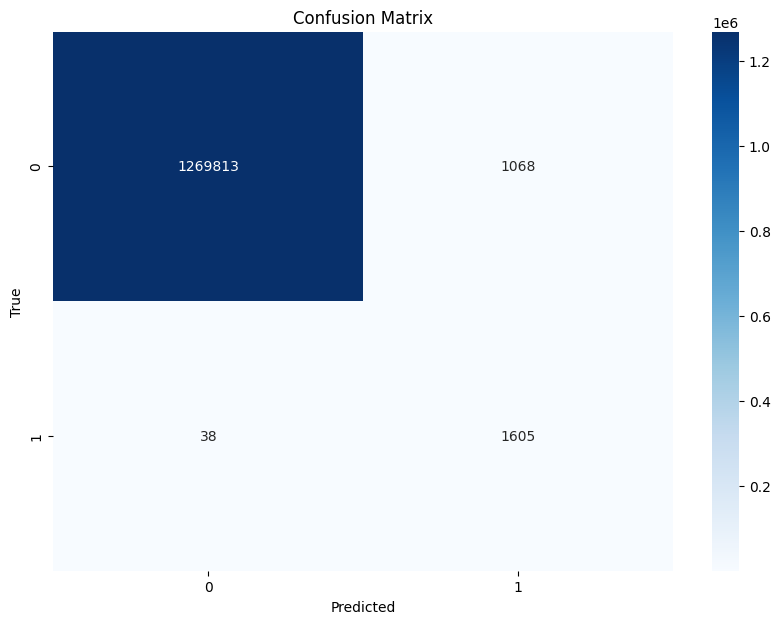

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.60      0.98      0.74      1643

    accuracy                           1.00   1272524
   macro avg       0.80      0.99      0.87   1272524
weighted avg       1.00      1.00      1.00   1272524



In [43]:
# Calculate the confusion matrix
cm = confusion_matrix(y_val, y_pred_xg_final)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Additionally, you can print the classification report for more detailed metrics
print("Classification Report:")
print(classification_report(y_val, y_pred_xg_final))

### VIII. Results

a. How much will the company recieve if the model was deployed on unseen data?

In [61]:
val_df = x_val.with_columns(pl.Series(name="preds" ,values=y_pred_xg_final),
                           pl.Series(name="isfraud",values=y_val.to_numpy().flatten()))

In [59]:
total_amount = val_df.filter((pl.col("preds") == 1) & (pl.col("isfraud") == 1)).select(pl.sum("amount")).item()
total_amount = total_amount*0.15
formatted_amount = f"${total_amount:,.0f}"

print(f"The company receives a total of {formatted_amount} for detecting fraudulent transactions successfully.")

The company receives a total of $338,756,561 for detecting fraudulent transactions successfully.


b. The company will have a penalty of 3% of each transaction flagged as fraud but is legitimate. How much would it lose on the unseen data?

In [60]:
total_amount_lost = val_df.filter((pl.col("preds") == 1) & (pl.col("isfraud") == 0)).select(pl.sum("amount")).item()
total_amount_lost = total_amount_lost*0.15
formatted_amount_lost = f"${total_amount_lost:,.0f}"

print(f"The company has to pay a total of {formatted_amount_lost} for flagging as fraudulent transactions legitimate movements.")

The company receives a total of $32,251,006 for detecting fraudulent transactions successfully.


Is the company's product profitable?

Yes. According to the previous results we can see that the company recieves a total of $338 MM and only has to return \$32 MM due to missclassified transactions.